## Create local copy of dataset
#### Original dataset with multi-labels removed

In [3]:
import boto3
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
import os

In [4]:
# Set the S3 bucket paths
# Set up the S3 bucket paths
bucket_name = 'mkorphi-uibk-1'
s3_directory_key = 'Pos_only/'

In [5]:
# Local directory to save images
local_directory = 'local_image_directory_2'

# Create the local directory if it doesn't exist
if not os.path.exists(local_directory):
    os.makedirs(local_directory)

In [6]:
#### DO NOT RUN if don't want to create a local copy of dataset
RUN_THIS = True

s3 = boto3.client('s3')

# List all objects in the S3 directory
paginator = s3.get_paginator('list_objects_v2')
pages = paginator.paginate(Bucket=bucket_name, Prefix=s3_directory_key)
        
if RUN_THIS:
    # Download each image and recreate the folder structure
    for page in pages:
        for obj in page['Contents']:
            key = obj['Key']
            if key.endswith('/'):  # Skip directories
                continue
            # Recreate the directory structure locally
            relative_path = os.path.relpath(key, s3_directory_key)
            local_file_path = os.path.join(local_directory, relative_path)
            local_file_dir = os.path.dirname(local_file_path)
            if not os.path.exists(local_file_dir):
                os.makedirs(local_file_dir)
            # Download the file
            s3.download_file(bucket_name, key, local_file_path)

else:
    print("Skipped downloading images from s3")

### Load Classification model
##### This model was trained on cropped / zoomed in images

In [7]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from tensorflow.data import Dataset
from collections import Counter
from collections import defaultdict
import matplotlib.pyplot as plt

2024-07-17 05:09:28.703371: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512F AVX512_VNNI
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-17 05:09:28.830760: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2024-07-17 05:09:28.830871: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:105] SageMaker Profiler is not enabled. The timeline writer thread will not be started, future recorded events will be dropped.
2024-07-17 05:09:28.831067: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-1

In [8]:
# Load the pre-trained model
model_path = 'models/EfficientNetV2S_best_model_2'
model = tf.keras.models.load_model(model_path)

2024-07-17 05:09:33.970148: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-17 05:09:33.978739: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-17 05:09:33.980383: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-17 05:09:33.982418: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512F AVX512_VNNI
To enable them in other operations, rebu

### Sanity Check performance on test cropped dataset

In [9]:
# Define the path to the new dataset
dataset_path = 'local_image_directory/test'

# Load the dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    image_size=(224, 224),  # Resize images to the size expected by your model
    batch_size=32,  # Set batch size as per your requirement
    shuffle=True  # Shuffle the dataset
)


Found 1098 files belonging to 3 classes.


In [10]:
# Evaluate the model on the new dataset
loss, accuracy = model.evaluate(dataset)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')


2024-07-17 05:10:05.016832: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8204


35/35 [==============================] - 19s 214ms/step - loss: 0.5429 - accuracy: 0.7905
Loss: 0.5429201126098633
Accuracy: 0.7905282378196716


### Now Check performance on original dataset (with multi labels removed)

In [11]:
# Define the path to the new dataset
dataset_path = 'local_image_directory_2'

# Load the dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    image_size=(224, 224),  # Resize images to the size expected by your model
    batch_size=32,  # Set batch size as per your requirement
    shuffle=True  # Shuffle the dataset
)


Found 1035 files belonging to 3 classes.


In [12]:
def get_class_samples(dataset):
    class_samples = defaultdict(list)
    for images, labels in dataset:
        for i in range(len(labels)):
            class_samples[labels[i].numpy()].append(images[i].numpy())
    return class_samples

def undersample(class_samples, minority_class_size):
    balanced_samples = []
    for label, samples in class_samples.items():
        np.random.shuffle(samples)
        balanced_samples.extend([(sample, label) for sample in samples[:minority_class_size]])
    np.random.shuffle(balanced_samples)
    return balanced_samples

# Get samples for each class
class_samples = get_class_samples(dataset)

# Find the size of the smallest class
minority_class_size = min(len(samples) for samples in class_samples.values())

# Undersample to create a balanced dataset
balanced_samples = undersample(class_samples, minority_class_size)

# Convert the balanced samples back to a TensorFlow dataset
def generator():
    for sample, label in balanced_samples:
        yield sample, label

balanced_dataset = tf.data.Dataset.from_generator(generator, output_signature=(
    tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32),
    tf.TensorSpec(shape=(), dtype=tf.int64)
)).batch(32)


In [13]:
# Evaluate on test dataset
test_loss, test_acc = model.evaluate(balanced_dataset, verbose=2)
print(f'\nTest accuracy: {test_acc}')

# Generate predictions for the test dataset
test_predictions = model.predict(balanced_dataset)
test_predictions = np.argmax(test_predictions, axis=1)

# Extract true labels from the test dataset
test_labels = np.concatenate([y for x, y in balanced_dataset], axis=0)

33/33 - 7s - loss: 0.8346 - accuracy: 0.6454 - 7s/epoch - 220ms/step

Test accuracy: 0.6454106569290161
33/33 [==============================] - 6s 111ms/step


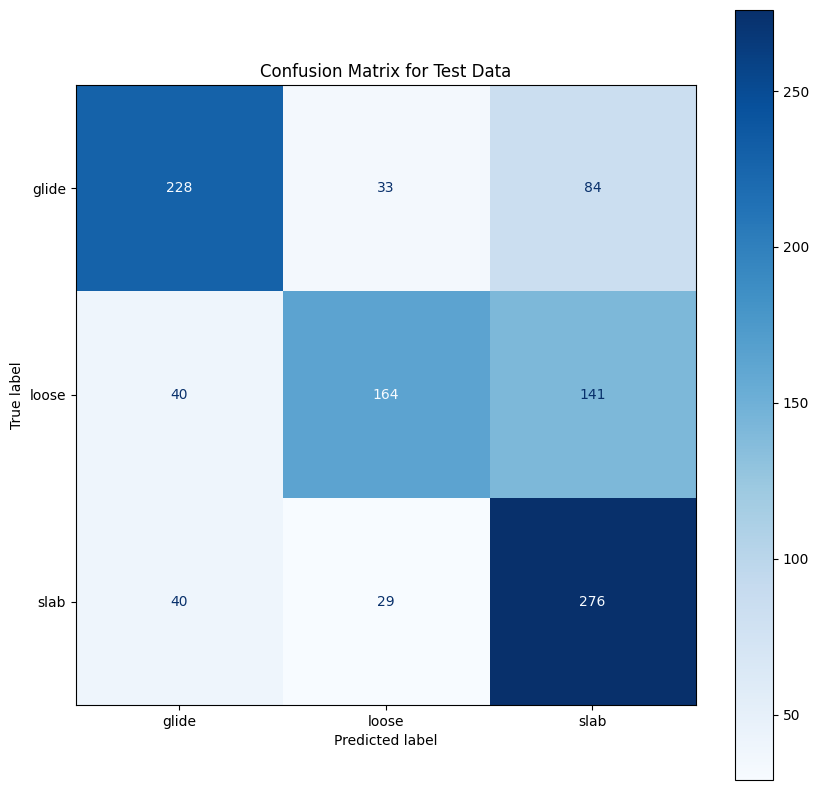

In [14]:
# Compute the confusion matrix
cm = confusion_matrix(test_labels, test_predictions)

# Plot the confusion matrix with a customized color map
fig, ax = plt.subplots(figsize=(10, 10))
cmd = ConfusionMatrixDisplay(cm, display_labels=dataset.class_names)
cmd.plot(ax=ax, cmap='Blues')  # Use the 'Blues' colormap
plt.title('Confusion Matrix for Test Data')
plt.show()

In [15]:
# Compute the classification report including F1-score
class_report = classification_report(test_labels, test_predictions, target_names=dataset.class_names)
print('\nClassification Report:\n', class_report)


Classification Report:
               precision    recall  f1-score   support

       glide       0.74      0.66      0.70       345
       loose       0.73      0.48      0.57       345
        slab       0.55      0.80      0.65       345

    accuracy                           0.65      1035
   macro avg       0.67      0.65      0.64      1035
weighted avg       0.67      0.65      0.64      1035



### Class activation maps

In [16]:
# Inspect the model layers to find the last convolutional layer
for layer in model.layers[::-1]:
    if isinstance(layer, tf.keras.layers.Conv2D):
        last_conv_layer_name = layer.name
        break

print(f'The last convolutional layer is: {last_conv_layer_name}')


The last convolutional layer is: top_conv


In [17]:
def get_img_array(img_path, size):
    """Load image and convert to array."""
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """Generate grad-CAM heatmap."""
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img_path, heatmap, alpha=0.4):
    """Display grad-CAM heatmap."""
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)
    jet = plt.cm.get_cmap("jet")

    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()


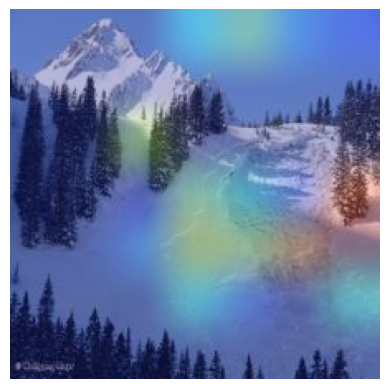

In [21]:
# Define the image path
img_path = 'local_image_directory_2/slab/2012-02-21 ausserfern (78).jpg'

# Load the image and preprocess
img_size = (224, 224)
img_array = get_img_array(img_path, img_size)

# Generate grad-CAM heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
display_gradcam(img_path, heatmap)
